# Stroke pathway timing distribution

## Aim

Visualise distributions of timings for:

* Onset to arrival (when known)
* Arrival to scan
* Scan to needle

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# import data
raw_data = pd.read_csv(
    './../data/2019-11-04-HQIP303-Exeter_MA.csv', low_memory=False)

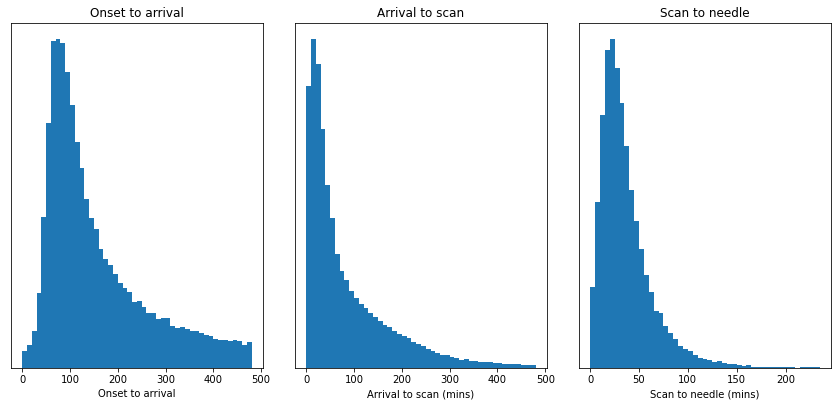

In [2]:
# Set up figure
fig = plt.figure(figsize=(12,6))

# Subplot 1: Histogram of onset to arrival

onset_to_arrival = raw_data['S1OnsetToArrival_min']
# Limit to arrivals within 8 hours
mask = onset_to_arrival <= 480
onset_to_arrival = onset_to_arrival[mask]

ax1 = fig.add_subplot(131)
bins = np.arange(0, 481, 10)
ax1.hist(onset_to_arrival, bins=bins, rwidth=1.0)
ax1.set_xlabel('Onset to arrival')
ax1.set_ylabel('Count')
ax1.set_title('Onset to arrival')
ax1.axes.get_yaxis().set_visible(False)


# Subplot 2: Histogram of arrival to scan

arrival_to_scan = raw_data['S2BrainImagingTime_min']
# Limit to arrivals within 4 hours
mask = arrival_to_scan <= 480
arrival_to_scan = arrival_to_scan[mask]

ax2 = fig.add_subplot(132)
bins = np.arange(0, 481, 10)
ax2.hist(arrival_to_scan, bins=bins, rwidth=1)
ax2.set_xlabel('Arrival to scan (mins)')
ax2.set_ylabel('Count')
ax2.set_title('Arrival to scan')
ax2.axes.get_yaxis().set_visible(False)

# Subplot 2: Histogram of scan to needle

scan_to_needle = \
    raw_data['S2ThrombolysisTime_min'] - raw_data['S2BrainImagingTime_min']

ax3 = fig.add_subplot(133)
bins = np.arange(0, 240, 5)
ax3.hist(scan_to_needle, bins=bins, rwidth=1)
ax3.set_xlabel('Scan to needle (mins)')
ax3.set_ylabel('Count')
ax3.set_title('Scan to needle')
ax3.axes.get_yaxis().set_visible(False)


# Save and show
plt.tight_layout(pad=2)
plt.savefig('output/pathway_distribution.jpg', dpi=300)
plt.show();

## Fit distributions

### Define function to fit distributions

In [3]:
def fit_distributions(data_to_fit):   
    
    # Reshape data and remove invalid values
    yy = data_to_fit.values
    mask = (yy > 0) & (yy < np.inf)
    yy = yy[mask]
    
    # Bootstrap sample 10k samples
    yy = np.random.choice(yy, 10000, replace=True)
    
    # Reshape
    yy = yy.reshape (-1,1)
    size = len(yy)
    
    # Standardise data
    sc = StandardScaler()
    sc.fit(yy)
    y_std = sc.transform(yy)
    
    # Add +/- 0.001 jitter to avoid failure of fit
    jitter = np.random.uniform(-0.001, 0.001, 10000)
    jitter = jitter.reshape (-1,1)
    y_std += jitter
    
    # Test 10 distributions
    dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']
    
    # Set up empty lists to stroe results
    chi_square = []
    p_values = []
    
    # Set up 50 bins for chi-square test
    # Observed data will be approximately evenly distrubuted aross all bins
    percentile_bins = np.linspace(0,100,51)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)
    
    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(y_std, distribution, args=param)[1]
        p = np.around(p, 5)
        p_values.append(p)    

        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # calculate chi-squared
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / 
                  cum_observed_frequency)
        chi_square.append(ss)
        
        # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    results.sort_values(['chi_square'], inplace=True)

    # Report results

    print ('\nDistributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)

### Fit distributions to onset-to-arrival

In [4]:
onset_to_arrival = raw_data['S1OnsetToArrival_min']
# Censor at 8 hours
mask = onset_to_arrival <= 480
onset_to_arrival = onset_to_arrival[mask]
fit_distributions(onset_to_arrival)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm   1035.973629      0.0
2        gamma   2867.577302      0.0
5     pearson3   2867.877770      0.0
9  weibull_max   4346.740179      0.0
8  weibull_min   5544.402156      0.0
6       triang   9628.460031      0.0
4         norm  18830.063675      0.0
7      uniform  38428.238166      0.0
1        expon  53905.993560      0.0
0         beta  92182.354188      0.0


### Fit distributions to arrival-to-scan

In [5]:
arrival_to_scan = raw_data['S2BrainImagingTime_min']
# Censor at 8 hours
mask = arrival_to_scan <= 480
arrival_to_scan = arrival_to_scan[mask]
fit_distributions(arrival_to_scan)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm    1043.244304      0.0
8  weibull_min    1242.414276      0.0
2        gamma    1900.433438      0.0
5     pearson3    1909.613959      0.0
1        expon    2122.071088      0.0
0         beta    3924.046486      0.0
9  weibull_max   25326.018898      0.0
6       triang   55942.946250      0.0
4         norm   59422.248827      0.0
7      uniform  112924.720088      0.0


### Fit distributions to scan-to-needle

In [6]:
scan_to_needle = \
    raw_data['S2ThrombolysisTime_min'] - raw_data['S2BrainImagingTime_min']
fit_distributions(scan_to_needle)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm     156.464194      0.0
5     pearson3     625.603158      0.0
0         beta     709.696904      0.0
8  weibull_min    2381.501591      0.0
9  weibull_max    3229.290860      0.0
1        expon   21832.942628      0.0
4         norm   27966.447333      0.0
6       triang  156575.354540      0.0
7      uniform  196413.310249      0.0
2        gamma  668068.407184      0.0


## Observations

* All timings show a right skew, with lognormal having minimum chi-squared
* Choose log normal distributions for pathway process times